# Portfolio Optimization 

## Import packages and load data

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from pypfopt import plotting, objective_functions, risk_models, EfficientFrontier

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('full_data.csv', index_col='Date', parse_dates=True)[:-1]
df = df[:'2022-10-23']
df.tail()

,ch,DBC.US,it,rf,SHEL,CSSMI.SW,WMT,EUR,CHF
Date,,,,,,,,,
2022-10-17,0.660,25.12,3.409,4.469,51.41,108.840,131.42,0.9838,0.9963
2022-10-18,0.629,24.82,3.423,4.465,51.43,109.640,134.19,0.9852,1.0045
2022-10-19,0.683,24.83,3.561,4.599,51.76,108.659,133.73,0.9771,1.0064
2022-10-20,0.700,24.86,3.531,4.684,52.01,108.700,134.05,0.9783,0.9952
2022-10-21,0.674,24.88,3.490,4.543,52.97,108.100,136.81,0.9860,0.9962


In [4]:
# df = pd.DataFrame()
# names = ['ch', 'dbc', 'it', 'rf', 'shel', 'smi', 'wmt']

# for n in names:
#     tmp = pd.read_excel(f'C:/Users/gobel/code/research_env/USI/financial_modelling/data/{n}.xlsx')
#     tmp.set_index(pd.to_datetime(tmp.Date), inplace=True)
#     tmp.columns = ['a', 'b']
#     df[n] = tmp.b

# df.columns = ['ch', 'DBC.US', 'it', 'rf', 'SHEL', 'CSSMI.SW', 'WMT']
# df = df.iloc[::-1]

ret = df.pct_change()
ret['ch'] = ret.CHF
ret['it'] = ret.EUR
ret.drop(['rf', 'CHF', 'EUR'], axis=1, inplace=True)
cov = risk_models.exp_cov(ret, span=756, returns_data=True)

<AxesSubplot: >

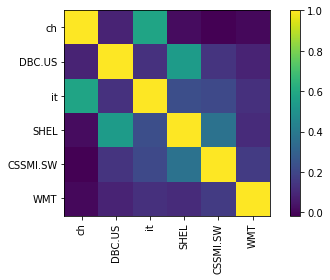

In [5]:
# sample_cov = risk_models.sample_cov(df, frequency=252)
# cov = risk_models.exp_cov(df, span=756, returns_data=False)
plotting.plot_covariance(cov, plot_correlation=True)

In [7]:
# Import our expected returns

mu = pd.read_csv('expected_returns.csv', index_col=0)['Posterior']

# Adjust the assets traded not in USD for the FX rate
mu['it'] = mu.it + mu.EUR 
mu['ch'] = mu.ch + mu.CHF
mu['CSSMI.SW'] = mu['CSSMI.SW'] + mu.CHF
mu.drop(['CHF', 'EUR'], inplace=True, axis=0)
mu

DBC.US      0.133122
SHEL        0.105648
CSSMI.SW    0.122030
WMT         0.108277
it          0.057279
ch          0.067282
Name: Posterior, dtype: float64

In [8]:
mu_clean = [mu[i] for i in cov.columns]

## Optimization

In [22]:
# Set our constraints on the asset classes. In our example 30% on Commodities (DBC & SHEL)
asset_classes = {
    'CSSMI.SW': 'EQ',
    'DBC.US': 'Com',
    'WMT': 'EQ',
    'SHEL': 'Com',
    'it': 'FI',
    'ch': 'FI'
}
asset_lower = {
}
asset_upper = {
    'Com': 0.3
    # 'FI': 0.25, 
    # 'EQ': 0.4, 
}

In [23]:
# test = {}

# for i in range(1, 50):
#     asset_upper = {
#         'Com': i/100
#     }
        
#     ef = EfficientFrontier(mu, cov)
#     ef.add_objective(objective_functions.L2_reg, gamma=1)
#     ef.add_sector_constraints(asset_classes, asset_lower, asset_upper)
#     ef.max_sharpe(risk_free_rate=0.04557)
#     w = np.array(list(ef.clean_weights().values()))

#     stats = ef.portfolio_performance(verbose=False)
#     test[i/100] = stats[2] 

In [26]:
# Actual Optimization part
ef = EfficientFrontier(mu_clean, cov)

# L2 regularization -> punish variance of weights
ef.add_objective(objective_functions.L2_reg, gamma=1)

# Add the above mentioned sector constraint
ef.add_sector_constraints(asset_classes, asset_lower, asset_upper)

# Maximize the sharpe ratio with the historical 5-year EMA risk-free
ef.max_sharpe(risk_free_rate=0.01827)
final_weights = np.array(list(ef.clean_weights().values()))
print(final_weights)

stats = ef.portfolio_performance(verbose=True)

[0.13324 0.18868 0.1084  0.11132 0.247   0.21136]
Expected annual return: 10.5%
Annual volatility: 11.8%
Sharpe Ratio: 0.73


In [14]:
ef.clean_weights()

OrderedDict([('ch', 0.13324),
             ('DBC.US', 0.18868),
             ('it', 0.1084),
             ('SHEL', 0.11132),
             ('CSSMI.SW', 0.247),
             ('WMT', 0.21136)])

In [16]:
# Create Random portfolios for the visualization

n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu_clean)), n_samples)
rets = w.dot(mu_clean)
stds = np.sqrt((w.T * (cov @ w.T)).sum(axis=0))
sharpes = rets / stds

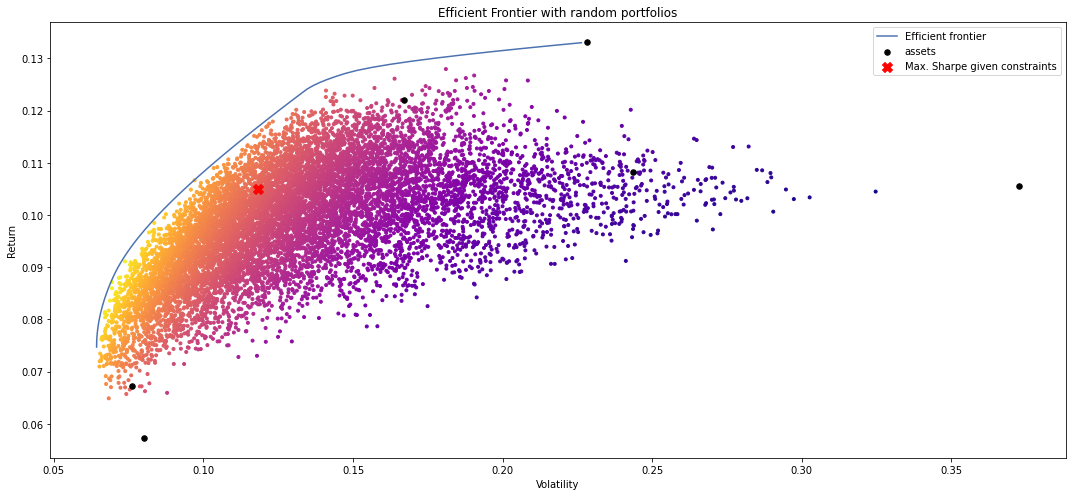

In [17]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ef = EfficientFrontier(mu_clean, cov)
# ef2.add_objective(objective_functions.L2_reg, gamma=0.1) 
ef2 = EfficientFrontier(mu_clean, cov)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

ax.scatter(stds, rets, marker=".", c=sharpes, cmap="plasma")
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
ax.scatter(x=stats[1], y=stats[0], marker='X', s=100, color='r', label='Max. Sharpe given constraints')

ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()